In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# How next character will be produced given first three characters

block_size = 3  # context length: how many characters do we take to predict the next one
X, Y = [], []

for w in words[:5]:
    print(w)
    
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]   # crop and append
    
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [8]:
# Build full dataset

block_size = 3  # context lenght
X, Y = [], []

for w in words:
    
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]  # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [67]:
g = torch.Generator().manual_seed(214783647)  # for reproducaibility
C = torch.randn((27, 2), generator = g)   # size of embedding matrix (kept 2 for each character for visualisation)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [48]:
# total number of trainable parameters in neural network
sum(p.nelement() for p in parameters)

3481

In [68]:
for p in parameters:
    p.requires_grad = True

In [50]:
%%time
lossi = []
stepi = []
for i in range(100):
    # forward pass
    emb = C[X]  # (num_examples, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y)
#     print(loss.item())
    
    # backward_pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
        
    # store stats
    lossi.append(loss.item())
    stepi.append(i)
print(loss.item())

3.388873338699341
CPU times: total: 4min 46s
Wall time: 1min 16s


In [51]:
# Calculating loss over whole dataset finally
emb = C[X]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(3.3761, grad_fn=<NllLossBackward0>)

Text(0.5, 0, 'steps')

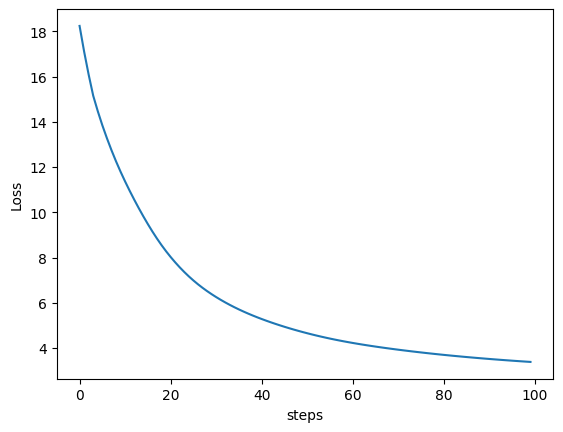

In [35]:
plt.plot(stepi, lossi)
plt.ylabel('Loss')
plt.xlabel('steps')

In [38]:
# as time required for forward and backward pass over whole dataset is quite high, so minibatches
# would overcome this limitation
# Gradient direction is not accurate for mini batch as we are only
# calculating loss for only 32 examples, but it is good enough to compensate
# the speed of training and take weights in correct direction

In [54]:
%time
lossi = []
stepi = []

for i in range(100):
    
    # minibatch construction
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
    
    # store stats
    lossi.append(loss.item())
    stepi.append(i)
    
print(loss.item())

CPU times: total: 0 ns
Wall time: 0 ns
3.6532652378082275


In case of minibatch, neural network trains instantaneoulsy. As loss is higher in comparison of Batch gradient Descent, we can train with minibatches for more epochs to get comparable loss. 

In [55]:
# Calculating loss over whole dataset finally
emb = C[X]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(3.8316, grad_fn=<NllLossBackward0>)

Text(0.5, 0, 'steps')

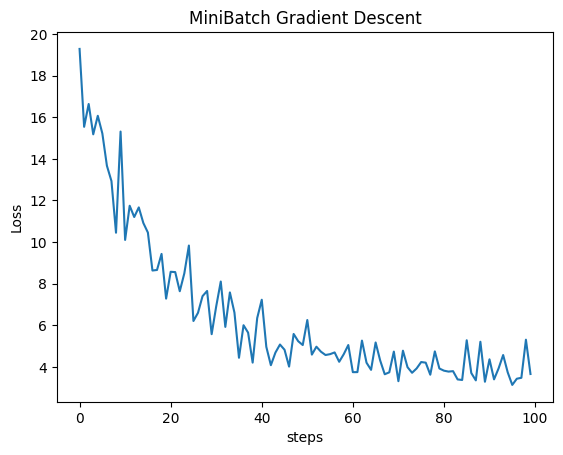

In [56]:
plt.title("MiniBatch Gradient Descent")
plt.plot(stepi, lossi)
plt.ylabel('Loss')
plt.xlabel('steps')

In [57]:
# Choosing right learning rate, grid search over values between 0.001 and 1
lre = torch.linspace(-3, 0, 1000)  # searching linearly over exponents
                                   # 10^-3 = 0.001 and 10^0 = 1
lrs = 10**lre

In [63]:
%%time
lri = []
lossi = []

for i in range(1000):
    
    # minibatch construction
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # updata parameters
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())
print(loss.item())

7.7593674659729
CPU times: total: 6.12 s
Wall time: 1.58 s


Text(0, 0.5, 'loss')

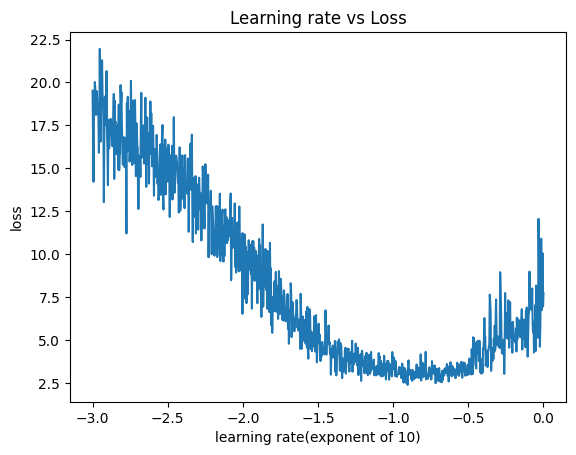

In [66]:
## learning rate is in terms of exponent of 10
plt.title("Learning rate vs Loss")
plt.plot(lri, lossi)
plt.xlabel("learning rate(exponent of 10)")
plt.ylabel("loss")

Learning rate = 0.1 seems suitable for training, as after this loss starts to increasing.
We can also decrease learning rate as number of epochs increases, this is called learning rate decay. As late stage of training, the weights moves toward becoming stable for the dataset, large change in learning rate can move weights away from suitable weights.

In [69]:
for i in range(30000):
    
    # minibatch construction
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # updata parameters
    if i < 20000:
        lr = 0.1
    else:
        lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
print(loss.item())

2.2281181812286377


In [71]:
# Calculating loss over whole dataset finally
emb = C[X]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3441, grad_fn=<NllLossBackward0>)

loss becomes low as we increased number of epochs, we can also try increasing number of neurons in a layer of neural network,as maybe our model is too simple and we are underfitting

In [80]:
g = torch.Generator().manual_seed(214783647)  # for reproducaibility
C = torch.randn((27, 2), generator = g)   # size of embedding matrix (kept 2 for each character for visualisation)
W1 = torch.randn((6, 300), generator = g)   # Using 300 neurons in layer 1
b1 = torch.randn(300, generator = g)
W2 = torch.randn((300, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [81]:
for p in parameters:
    p.requires_grad = True

In [82]:
%%time
lossi = []
stepi = []
for i in range(30000):
    
    # minibatch construction
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 300)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward_pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    if i < 20000:
        lr = 0.1
    else:
        lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # store stats
    lossi.append(loss.item())
    stepi.append(i)
print(loss.item())

2.079502820968628
CPU times: total: 1min 27s
Wall time: 22.5 s


In [83]:
# Calculating loss over whole dataset finally
emb = C[X]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.3321, grad_fn=<NllLossBackward0>)

Text(0.5, 0, 'steps')

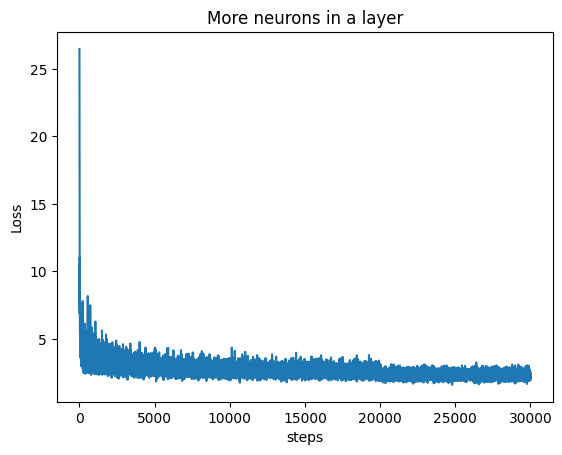

In [84]:
plt.title("More neurons in a layer")
plt.plot(stepi, lossi)
plt.ylabel('Loss')
plt.xlabel('steps')

Checking whether neural network is overfitting over training set is also necessary. If it overfits over training data then it will not perform good over data which it has never seen before. 
So, data is usually divided in 3 parts Training set, Dev(Validation) set & Test set.
Model is trained on training set, checked for overfit over dev set (while training) and finally tested over test set.

In [85]:
# Using training, validation an test sets

def build_dataset(words):
    block_size = 3  # context length
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [87]:
# initialize parameters
g = torch.Generator().manual_seed(214783467)
C = torch.randn((27, 2), generator = g)
W1 = torch.randn((6, 200), generator = g)
b1 = torch.randn(200)
W2 = torch.randn((200, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print("Number of parameters: ", sum(p.nelement() for p in parameters))

Number of parameters:  6881


In [97]:
steps = []
losstr = []

for i in range(50000):
    
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    if (i < 30000):
        lr = 0.1
    else:
        lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # # track stats
    steps.append(i)
    losstr.append(loss.log10().item())
print(loss.item())     

2.208604574203491


In [98]:
# Training loss over whole dataset
emb = C[Xtr]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2785, grad_fn=<NllLossBackward0>)

In [99]:
# Dev loss
emb = C[Xdev]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2816, grad_fn=<NllLossBackward0>)

As training and dev loss are quite similar, Dimension of embedding vector can also be a bottleneck in reducing loss. So next we will be increasing dimension of embedding vector from 2 to 10 for a character

Text(0.5, 0, 'steps')

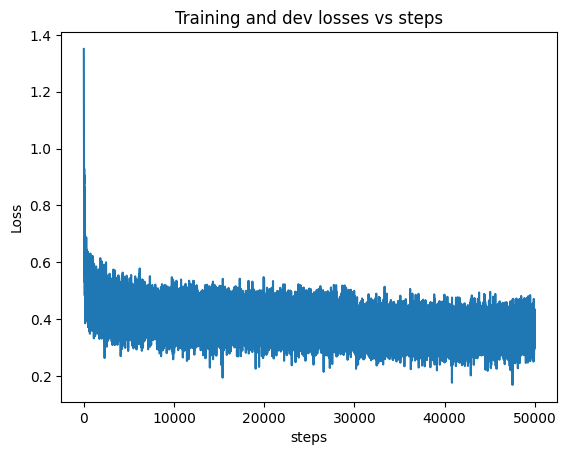

In [94]:
plt.title("Training and dev losses vs steps")
plt.plot(steps, losstr)
plt.ylabel('Loss')
plt.xlabel('steps')

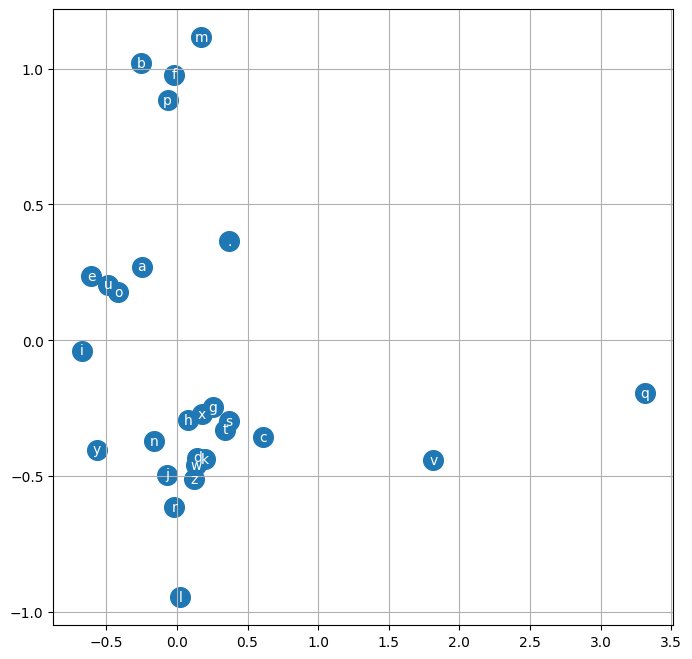

In [100]:
# Visualising Embeddings of characters in vector space
C.requires_grad = False
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0], C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [109]:
# Increase dimension of embedding vector from 2 to 10
# initialize parameters
g = torch.Generator().manual_seed(214783467)
C = torch.randn((27, 10), generator = g)
W1 = torch.randn((30, 300), generator = g)
b1 = torch.randn(300)
W2 = torch.randn((300, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
print("Number of parameters: ", sum(p.nelement() for p in parameters))

Number of parameters:  17697


In [110]:
for i in range(50000):
    
    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    if (i < 30000):
        lr = 0.1
    else:
        lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
print(loss.item())

2.456469774246216


In [111]:
emb = C[Xtr]  # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1829, grad_fn=<NllLossBackward0>)

In [112]:
emb = C[Xdev]  # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2161, grad_fn=<NllLossBackward0>)

In [115]:
# Sample from model

g = torch.Generator().manual_seed(21474833647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

kayleee.
cayli.
brealringylendylen.
yoh.
ach.
kia.
aza.
aluta.
isa.
jerahlena.
tewa.
anya.
lincelen.
gant.
mack.
hanayan.
bexan.
irevan.
samrerista.
mantvanaya.


In [116]:
# These names seems better than what bigram model generated :)